## Part 2: Clinical Application

### Contents
Fill out this notebook as part 2 of your final project submission.

**You will have to complete the Code (Load Metadata & Compute Resting Heart Rate) and Project Write-up sections.**  

- [Code](#Code) is where you will implement some parts of the **pulse rate algorithm** you created and tested in Part 1 and already includes the starter code.
  - [Imports](#Imports) - These are the imports needed for Part 2 of the final project. 
    - [glob](https://docs.python.org/3/library/glob.html)
    - [os](https://docs.python.org/3/library/os.html)
    - [numpy](https://numpy.org/)
    - [pandas](https://pandas.pydata.org/)
  - [Load the Dataset](#Load-the-dataset)  
  - [Load Metadata](#Load-Metadata)
  - [Compute Resting Heart Rate](#Compute-Resting-Heart-Rate)
  - [Plot Resting Heart Rate vs. Age Group](#Plot-Resting-Heart-Rate-vs.-Age-Group)
- [Project Write-up](#Project-Write-Up) to describe the clinical significance you observe from the **pulse rate algorithm** applied to this dataset, what ways/information that could improve your results, and if we validated a trend known in the science community. 

### Dataset (CAST)

The data from this project comes from the [Cardiac Arrythmia Suppression Trial (CAST)](https://physionet.org/content/crisdb/1.0.0/), which was sponsored by the National Heart, Lung, and Blood Institute (NHLBI). CAST collected 24 hours of heart rate data from ECGs from people who have had a myocardial infarction (MI) within the past two years.<sup>1</sup> This data has been smoothed and resampled to more closely resemble PPG-derived pulse rate data from a wrist wearable.<sup>2</sup>

1. **CAST RR Interval Sub-Study Database Citation** - Stein PK, Domitrovich PP, Kleiger RE, Schechtman KB, Rottman JN. Clinical and demographic determinants of heart rate variability in patients post myocardial infarction: insights from the Cardiac Arrhythmia Suppression Trial (CAST). Clin Cardiol 23(3):187-94; 2000 (Mar)
2. **Physionet Citation** - Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals (2003). Circulation. 101(23):e215-e220.

-----

### Code
#### Imports

When you implement the functions, you'll only need to you use the packages you've used in the classroom, like [Pandas](https://pandas.pydata.org/) and [Numpy](http://www.numpy.org/). These packages are imported for you here. We recommend you don't import other packages outside of the [Standard Library](https://docs.python.org/3/library/) , otherwise the grader might not be able to run your code.

In [1]:
import glob
import os

import numpy as np
import pandas as pd

#### Load the dataset

The dataset is stored as [.npz](https://docs.scipy.org/doc/numpy/reference/generated/numpy.savez.html) files. Each file contains roughly 24 hours of heart rate data in the 'hr' array sampled at 1Hz. The subject ID is the name of the file. You will use these files to compute resting heart rate.

Demographics metadata is stored in a file called 'metadata.csv'. This CSV has three columns, one for subject ID, age group, and sex. You will use this file to make the association between resting heart rate and age group for each gender.

Find the dataset in `../datasets/crisdb/`

In [17]:
data_path = os.path.join('.', 'datasets', 'crisdb')
hr_filenames = glob.glob(os.path.join(data_path, '*.npz'))

#### Load Metadata
Load the metadata file into a datastructure that allows for easy lookups from subject ID to age group and sex.

In [91]:
metadata_filename = os.path.join(data_path, 'metadata.csv')

# Load the metadata file into this variable.
metadata = pd.read_csv(metadata_filename)

In [92]:
def load_npz(subject):
    try:
        f = np.load(os.path.join(data_path, f'{subject}.npz'))
    except FileNotFoundError:
        return None
    
    return f

#### Compute Resting Heart Rate
For each subject we want to compute the resting heart rate while keeping track of which age group this subject belongs to. An easy, robust way to compute the resting heart rate is to use the lowest 5th percentile value in the heart rate timeseries.

In [109]:
def AgeAndRHR(metadata, filename):

    # Load the heart rate timeseries
    hr_data = np.load(filename)['hr']
    
    # Compute the resting heart rate from the timeseries by finding the lowest 5th percentile value in hr_data
    rhr = np.percentile(hr_data, 5)

    # Find the subject ID from the filename.
    subject = os.path.split(filename)[-1].split('.')[0]

    # Find the age group for this subject in metadata.
    age_group = metadata[metadata.subject == subject].age.values[0]
    
    # Find the sex for this subject in metadata.
    sex = metadata[metadata.subject == subject].sex.values[0]

    return age_group, sex, rhr

df = pd.DataFrame(data=[AgeAndRHR(metadata, filename) for filename in hr_filenames],
                  columns=['age_group', 'sex', 'rhr'])

In [110]:
df

,age_group,sex,rhr
0,60-64,Male,65.084746
1,60-64,Male,69.818182
2,65-69,Male,77.591753
3,65-69,Male,72.024615
4,55-59,Male,54.111052
...,...,...,...
1532,65-69,Male,71.111111
1533,50-54,Male,65.641026
1534,50-54,Male,70.300009
1535,70-74,Male,62.602544


#### Plot Resting Heart Rate vs. Age Group
We'll use [seaborn](https://seaborn.pydata.org/) to plot the relationship. Seaborn is a thin wrapper around matplotlib, which we've used extensively in this class, that enables higher-level statistical plots.

We will use [lineplot](https://seaborn.pydata.org/generated/seaborn.lineplot.html#seaborn.lineplot) to plot the mean of the resting heart rates for each age group along with the 95% confidence interval around the mean. Learn more about making plots that show uncertainty [here](https://seaborn.pydata.org/tutorial/relational.html#aggregation-and-representing-uncertainty).

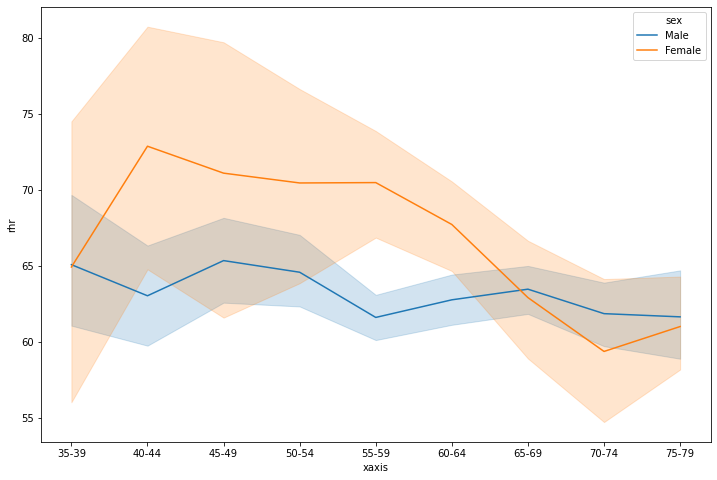

In [113]:
import seaborn as sns
from matplotlib import pyplot as plt

labels = sorted(np.unique(df.age_group))
df['xaxis'] = df.age_group.map(lambda x: labels.index(x)).astype('float')
plt.figure(figsize=(12, 8))
sns.lineplot(x='xaxis', y='rhr', hue='sex', data=df)
_ = plt.xticks(np.arange(len(labels)), labels)

### Clinical Conclusion
Answer the following prompts to draw a conclusion about the data.
> 1. For women, we see .... 
> 2. For men, we see ... 
> 3. In comparison to men, women's heart rate is .... 
> 4. What are some possible reasons for what we see in our data?
> 5. What else can we do or go and find to figure out what is really happening? How would that improve the results?
> 6. Did we validate the trend that average resting heart rate increases up until middle age and then decreases into old age? How?

Your write-up will go here...

In [136]:
maledf = df[df.sex == 'Male']
femaledf = df[df.sex == 'Female']

In [135]:
df.sex.value_counts()

Male      1260
Female     277
Name: sex, dtype: int64

## Conclusions

In this dataset we see a pronounced trend among women where the resting heart rate increases roughly 10bpm from the ages of 35-45, plateaus for 10-15 years after that, and then declines into old age. There is another upward trend as age increases from 70-74 to 75-79 but here we need to point out the relatively small number of samples for all the female age groups. Over half of our age buckets are less than 30 observations which makes them questionable in terms of our ability to draw conclusions from them. Stemming partially from this we also have high variance in the female observations.

In [146]:
femaledf.age_group.value_counts()

60-64    67
65-69    61
55-59    46
70-74    39
75-79    19
50-54    18
45-49    15
40-44     8
35-39     4
Name: age_group, dtype: int64

In [147]:
np.mean(femaledf.age_group.value_counts() < 30)

0.5555555555555556

For men there are no obvious trends other than a slight downward slope over time. We don't have the same issue as with women where a large number of these groups are small, so we would generally consider these observations to be more indicative of the ground truth. Overall the data suggests that women have higher resting heart rates than men, but given the difference in sample sizes and the high variance for women it's possible that this is a sampling error. 

In [138]:
maledf.age_group.value_counts()

60-64    246
65-69    230
55-59    215
70-74    157
50-54    146
45-49    109
75-79     79
40-44     54
35-39     24
Name: age_group, dtype: int64

In [148]:
np.mean(maledf.age_group.value_counts() < 30)

0.1111111111111111

The root question of this study is: Does heart rate increase in middle age before declining again as we get older? Ultimately this dataset feels insufficient for making a determination either way. To truly measure this we would want detailed heart observations of a potentially small group of individuals over a period of many years, not many observations of different people at different ages. We can't compare apples with apples, in other words. We are hoping that the sample sizes and the presence of a general trend irons out any inconsistencies in our data. 

Given that this phenomena is predicted to be present in the general population we should seek out additional data of healthy people, potentially not collected in a clinical setting (like data from wearable health devices). A larger dataset that we can be reasonably confident is clear of any significant selection bias would be a better tool for this.